In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tsne
t.manual_seed(1)

In [3]:
X=t.load('x.pt')#0,1二值化的
print(X.type)
X=t.from_numpy(PCA(n_components=30).fit_transform(X.numpy())).float()
C=t.load('labels.pt').float()
X=X[0:600]
C=C[0:600]
print(X.shape)
print(C.dtype)

<built-in method type of Tensor object at 0x7f46cd053bd0>
torch.Size([600, 30])
torch.float32


In [4]:
import pickle

In [5]:
f = r"../autodl-nas/IEMOCAP_data/IEMOCAP_leave_1_data.pkl"
with open(f, 'rb') as f:
    features = pickle.load(f)

print()

In [6]:
#! /usr/bin/env python
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
from center_loss import CenterLoss
from tqdm import tqdm
import pickle
import logging
import time
import random
import warnings
warnings.filterwarnings('ignore')
import torch.nn.functional as F
from dyrelu import DyReLUB
from data_loader_mfcc import DataSet


In [7]:
class RC_mdp_AFF(nn.Module):
    def __init__(self, DyRELU=True, Center=True, Gender=True, if_bidirectional=False, inter_channels=32):
        super(RC_mdp_AFF, self).__init__()

        # ------------------CNN-DEFINE------------------#
        self.DyRELU = DyRELU
        self.Center = Center
        self.Gender = Gender

        self.in_features = 64+128
        self.conv1 = nn.Conv2d(kernel_size=(3, 3), in_channels=1, out_channels=8)
        self.conv2 = nn.Conv2d(kernel_size=(3, 3), in_channels=8, out_channels=32, padding=1)
        # self.conv3 = nn.Conv2d(kernel_size=(3, 3), in_channels=16, out_channels=32, padding=1)
        self.conv4 = nn.Conv2d(kernel_size=(3, 3), in_channels=32, out_channels=64, padding=1)
        self.conv5 = nn.Conv2d(kernel_size=(3, 3), in_channels=64, out_channels=96, padding=1)
        self.conv6 = nn.Conv2d(kernel_size=(3, 3), in_channels=96, out_channels=128, padding=1)
        # self.conv7 = nn.Conv2d(kernel_size=(3, 3), in_channels=256, out_channels=512, padding=1)

        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(32)
        # self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(96)
        self.bn6 = nn.BatchNorm2d(128)
        # self.bn7 = nn.BatchNorm2d(512)

        if self.DyRELU:
            self.relu1 = DyReLUB(8, conv_type='2d')
            self.relu2 = DyReLUB(32, conv_type='2d')
            # self.relu3 = DyReLUB(32, conv_type='2d')
            self.relu4 = DyReLUB(64, conv_type='2d')
            self.relu5 = DyReLUB(96, conv_type='2d')
            self.relu6 = DyReLUB(128, conv_type='2d')
            # self.relu7 = DyReLUB(512, conv_type='2d')
        else:
            self.relu1 = nn.ReLU()
            self.relu2 = nn.ReLU()
            self.relu3 = nn.ReLU()
            self.relu4 = nn.ReLU()
            self.relu5 = nn.ReLU()
            self.relu6 = nn.ReLU()

        self.maxp = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout = nn.Dropout(0.1)
        self.pool = nn.AdaptiveAvgPool2d(1)

        # ------------------LSTM-DEFINE------------------#
        self.mid_features = 1024
        self.num_layers = 1
        self.if_bidirectional = if_bidirectional
        if self.if_bidirectional:
            self.mid_features = int(self.mid_features / 2)

        # self.norm = nn.LayerNorm(3*60)

        # self.linear = nn.Linear(in_features=3*60, out_features=3*60)

        self.lstm = nn.LSTM(
            input_size=3*60, hidden_size=self.mid_features, num_layers=self.num_layers,
            batch_first=True, bidirectional=self.if_bidirectional
        )

        # self.prelu = nn.PReLU()

        # ------------------CONCAT-DEFINE------------------#
        self.inter_channels = int(inter_channels)
        self.static_channels = 128
        self.dynamic_channels = 64

        self.static_local_att = nn.Sequential(
            nn.Conv2d(self.static_channels, self.inter_channels, kernel_size=(1,1)),
            nn.BatchNorm2d(self.inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.inter_channels, self.static_channels, kernel_size=(1,1)),
            nn.BatchNorm2d(self.static_channels),
        )

        self.static_global_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.static_channels, self.inter_channels, kernel_size=(1,1)),
            nn.BatchNorm2d(self.inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.inter_channels, self.dynamic_channels, kernel_size=(1,1)),
            nn.BatchNorm2d(self.dynamic_channels),
        )

        self.dynamic_local_att = nn.Sequential(
            nn.Conv2d(self.dynamic_channels, self.inter_channels, kernel_size=(1,1)),
            nn.BatchNorm2d(self.inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.inter_channels, self.dynamic_channels, kernel_size=(1,1)),
            nn.BatchNorm2d(self.dynamic_channels),
        )

        self.dynamic_global_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.dynamic_channels, self.inter_channels, kernel_size=(1,1)),
            nn.BatchNorm2d(self.inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.inter_channels, self.static_channels, kernel_size=(1,1)),
            nn.BatchNorm2d(self.static_channels),
        )

        self.sigmoid = nn.Sigmoid()

        # ------------------CLASSIFY-DEFINE------------------#
        self.integral_fc_emotion = nn.Linear(in_features=self.in_features, out_features=4)
        if self.Center:
            self.integral_fc_emotion_center = nn.Linear(in_features=self.in_features, out_features=4)
        if self.Gender:
            self.integral_fc_sex = nn.Linear(in_features=self.in_features, out_features=2)
        if self.Center and self.Gender:
            self.integral_fc_sex_center = nn.Linear(in_features=self.in_features, out_features=2)

    def forward(self, *input):
        # ------------------CNN-FORWARD------------------#
        #print("input[0]: ", input[0].shape)
        input_cnn = input[0].unsqueeze(1)
        #print("input_cnn: ", input_cnn.shape)
        x1_cnn = self.conv1(input_cnn)
        x1_cnn = self.bn1(x1_cnn)
        x1_cnn = self.relu1(x1_cnn)
        #print("x1_cnn: ", x1_cnn.shape)

        x2_cnn = self.conv2(x1_cnn)
        x2_cnn = self.bn2(x2_cnn)

        x2_cnn = self.relu2(x2_cnn)
        #print("x2_cnn: ", x2_cnn.shape)

        # x3_cnn = self.maxp(x2_cnn)
        # x3_cnn = self.conv3(x3_cnn)
        # x3_cnn = self.bn3(x3_cnn)
        #
        # x3_cnn = self.relu3(x3_cnn)

        x4_cnn = self.maxp(x2_cnn)
        x4_cnn = self.conv4(x4_cnn)
        x4_cnn = self.bn4(x4_cnn)

        x4_cnn = self.relu4(x4_cnn)
        #print("x4_cnn: ", x4_cnn.shape)

        x5_cnn = self.maxp(x4_cnn)
        x5_cnn = self.conv5(x5_cnn)
        x5_cnn = self.bn5(x5_cnn)

        x5_cnn = self.relu5(x5_cnn)
        #print("x5_cnn: ", x5_cnn.shape)

        #
        x6_cnn = self.maxp(x5_cnn)
        x6_cnn = self.conv6(x6_cnn)
        x6_cnn = self.bn6(x6_cnn)

        x6_cnn = self.relu6(x6_cnn)
        #print("x6_cnn: ", x6_cnn.shape)
        # x7_cnn = self.maxp(x6_cnn)
        # x7_cnn = self.conv7(x7_cnn)
        # x7_cnn = self.bn7(x7_cnn)
        #
        # x7_cnn = self.relu7(x7_cnn)

        x_cnn = self.dropout(x6_cnn)
        # x_cnn = self.dropout(x5_cnn)
        #print("x_cnn: ", x_cnn.shape)
        # print('attn: ', attn.shape)
        # x_static = self.pool(x_cnn)
        # x_static = torch.reshape(x_static, (x_static.shape[0], x_static.shape[1]))

        # ------------------LSTM-FORWARD------------------#
        #print("input[1]: ", input[1].shape)
        input_rnn = input[1].permute(0,2,1)
        #print("input_rnn: ", input_rnn.shape)
        # x_w = self.linear(torch.mean(x, dim=2).reshape(x.shape[0], x.shape[-1]))

        # input_weights = torch.softmax(torch.autograd.Variable(torch.ones(x.shape[0], 3), requires_grad = True).cuda(), dim=-1).unsqueeze(-1).unsqueeze(-1)
        # input_weights = input_weights.expand(x.shape[0], 3,  x.shape[2], x.shape[3])
        #
        # input_rnn = torch.mul(x, input_weights).reshape(x.shape[0], x.shape[2], x.shape[1]*x.shape[3])



        #
        #print(input_rnn.shape)

        # x1 = self.norm(x1.reshape(-1, x1.shape[1]))
        # input_rnn = x1.permute(0, 2, 1)
        # input_rnn = torch.cat((x1,x2, x3), dim=-1)
        x_lstm, (h_n, h_c) = self.lstm(input_rnn, None)  # (batch, time_step, input_size)
        # x_dynamic = self.prelu(x_dynamic[:, -1, :])
        # x_dynamic = self.prelu(x_dynamic)
        #print("x_lstm: ", x_lstm.shape)
        # x_dynamic = x_dynamic[:, -1, :]
        x_lstm = self.dropout(x_lstm)
        #print("x_lstm: ", x_lstm.shape)
        x_lstm = nn.AdaptiveAvgPool1d(64)(x_lstm)
        #print("x_lstm: ", x_lstm.shape)
        # ------------------CONCAT-FORWARD------------------#

        x_static = x_cnn
        x_dynamic = x_lstm.permute(0,2,1).unsqueeze(2)
        #print("x_static: ", x_static.shape)
        #print("x_dynamic: ", x_dynamic.shape)

        x_s_local = self.static_local_att(x_static)
        x_s_global = self.static_global_att(x_static)
        x_d_local = self.dynamic_local_att(x_dynamic)
        x_d_global = self.dynamic_global_att(x_dynamic)

        #print("x_s_local: ", x_s_local.shape)
        #print("x_s_global: ", x_s_global.shape)
        #print("x_d_local: ", x_d_local.shape)
        #print("x_d_global: ", x_d_global.shape)



        w_d = self.sigmoid(x_s_global + x_d_local)
        w_s = self.sigmoid(x_d_global + x_s_local)

        #print("w_d: ", w_d.shape)
        #print("w_s: ", w_s.shape)
        #print('x_d: ', x_d.shape)

        x_static = torch.mul(x_static, w_s)
        x_dynamic = torch.mul(x_dynamic, w_d)

        # print(x_static.shape, x_dynamic.shape)
        #print("x_static: ", x_static.shape)
        #print("x_dynamic: ", x_dynamic.shape)
        # self.pool(x_cnn).reshape(x_static.shape[0], x_static.shape[1]),
        #                            torch.mean(x_lstm, dim=-1).reshape(x_lstm.shape[0], x_lstm.shape[1]),

        out_x = torch.cat((
                           self.pool(x_static).reshape(x_static.shape[0], x_static.shape[1]),
                           self.pool(x_dynamic).reshape(x_dynamic.shape[0], x_dynamic.shape[1])), dim=-1)
        #print('out_x: ', out_x.shape)

        # out_x = torch.cat((x_static, x_dynamic),0)
        # out_x = torch.cat((out_x, x_fusion),0)

        out_emotion = self.integral_fc_emotion(out_x)
        #print('out_emotion: ', out_emotion.shape)
        if self.Gender and self.Center:
            out_sex = self.integral_fc_sex(out_x)
            out_sex_center = self.integral_fc_sex_center(out_x)
            out_emotion_center = self.integral_fc_emotion_center(out_x)
            return out_x, out_emotion, out_sex, out_emotion_center, out_sex_center
        if self.Gender:
            out_sex = self.integral_fc_sex(out_x)
            return out_x, out_emotion, out_sex
        if self.Center:
            out_emotion_center = self.integral_fc_emotion_center(out_x)
            return out_x, out_emotion, out_emotion_center
        else:
            return out_x, out_emotion
        # ------------------END-FORWARD------------------#

In [17]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


# setup_seed(111111)
# setup_seed(123456)
# setup_seed(0)
# setup_seed(999999)
def train(dataset, feature_type, data_num, root_dir, para):
    setup_seed(987654)

    # # logger setting
    # logger = logging.getLogger()
    # logger.setLevel(logging.INFO)  # Log等级总开关
    #
    # # 第二步，创建一个handler，用于写入日志文件
    # log_dir = root_dir + r'{}/{}_res/{}/{}_loggings/'.format(dataset, model_name, feature_type, feature_type)
    # # log_name = r'E:/code/emotion_analysis/datasets/wav/RC-md-AFF/{}_loggings/train_{}_{}.log'.format(feature_type, dataset, data_num)
    # if not os.path.exists(log_dir):
    #     os.makedirs(log_dir)
    # logfile = log_dir + 'train_{}_{}.log'.format(dataset, data_num)
    # fh = logging.FileHandler(logfile, mode='w')
    # fh.setLevel(logging.DEBUG)  # 输出到file的log等级的开关
    #
    # # 第三步，定义handler的输出格式
    # formatter = logging.Formatter("%(asctime)s - %(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s")
    # fh.setFormatter(formatter)
    #
    # # 第四步，将logger添加到handler里面
    # logger.addHandler(fh)

    # parameters setting
    alpha = 0.7
    beta = 0.3
    center_rate = 0.15
    learning_rate = 0.0005
    lr_cent = 0.1
    Epoch = 30
    BatchSize = 32
    
    #tsne
    out_tsne = []

    # MODEL_NAME='MULITMANET_with_gender'

    # MODEL_PATH = './model_result/IEMOCAP.pth'.format(str(case),element, file_num)

    # load features file
    print('load features data ...')
    logging.info('load features data...')
    # file = r'/home/IEMOCAP_leave_{}_data.pkl'.format(data_num)
    if dataset == 'IEMOCAP':
        file = r'../autodl-nas/IEMOCAP_data/IEMOCAP_leave_{}_data.pkl'.format(str(data_num + 1))
    elif dataset == 'MSP':
        file = r'../autodl-nas/MSP_data/MSP_leave_{}_data.pkl'.format(str(data_num))
    elif dataset == 'MELD':
        file = r'../data/MELD_data/MELD_data_{}.pkl'.format(str(data_num))
    else:
        print('Wrong dataset name!')

    with open(file, 'rb') as f:
        features = pickle.load(f)

    if dataset == 'IEMOCAP':
        val_X = features['valid_x']
        val_delta_X = features['valid_d']  # delta
        val_delta2_X = features['valid_dd']  # delta

        val_y = features['valid_emo']
        val_sex = features['valid_sex']

        train_X = features['train_x']
        train_delta_X = features['train_d']
        train_delta2_X = features['train_dd']

        train_y = features['train_emo']
        train_sex = features['train_sex']

    elif dataset == 'MSP':
        '''
        'train_x': train_x,
        'train_d': train_d,
        'train_dd': train_dd,
        'train_emo': train_emo,
        'train_sex': train_sex,

        'valid_x': valid_x,
        'valid_d': valid_d,
        'valid_dd': valid_dd,
        'valid_emo': valid_emo,
        'valid_sex': valid_sex
        '''
        val_X = features['valid_x']
        val_delta_X = features['valid_d']  # delta
        val_delta2_X = features['valid_dd']  # delta

        val_y = features['valid_emo']
        val_sex = features['valid_sex']

        train_X = features['train_x']
        train_delta_X = features['train_d']
        train_delta2_X = features['train_dd']

        train_y = features['train_emo']
        train_sex = features['train_sex']

    elif dataset == 'MELD':
        val_X = np.array(features['valid_x'])
        val_delta_X = np.array(features['valid_x_delta'])  # delta
        val_delta2_X = np.array(features['valid_x_delta2'])  # delta

        val_y = np.array(features['valid_emo'])
        val_sex = np.array(features['valid_sex'])

        train_X = np.array(features['train_x'])
        train_delta_X = np.array(features['train_x_delta'])
        train_delta2_X = np.array(features['train_x_delta2'])

        train_y = np.array(features['train_emo'])
        train_sex = np.array(features['train_sex'])

    else:
        print('unknown dataset')

    print(train_X.shape)

    '''training processing'''
    print('start training...')
    # logging.info('start training....')

    # load data
    #  train_trans, train_trans_len,
    train_data = DataSet(train_X, train_delta_X, train_delta2_X, train_y, train_sex)  # 加上 delta
    train_loader = DataLoader(train_data, batch_size=BatchSize, shuffle=True)

    # load model
    # ahead_text = 7, ahidden_text = 96

    rc_mdp_aff = RC_mdp_AFF()

    if torch.cuda.is_available():
        rc_mdp_aff = rc_mdp_aff.cuda()

    # criterion
    criterion = nn.CrossEntropyLoss()
    center_loss = CenterLoss(num_classes=4, feat_dim=4, use_gpu=True)
    center_loss_sex = CenterLoss(num_classes=2, feat_dim=2, use_gpu=True)

    params = list(rc_mdp_aff.parameters()) + list(center_loss.parameters()) + list(center_loss_sex.parameters())
    optimizer = optim.Adam(params, lr=learning_rate, weight_decay=1e-6)

    # result saving
    maxWA = 0
    maxUA = 0
    totalrunningtime = 0

    for ep in range(Epoch):
        start_time = time.time()
        # tq = tqdm(len(train_y))

        rc_mdp_aff.train()
        print_loss = 0

        for _, data in tqdm(enumerate(train_loader)):
            # x, delta_x, delta_delta_x, y, sex
            x1, x2, x3, y, sex = data
            if feature_type == "mfcc":
                x = x1
            elif feature_type == "delta":
                x = x2
            elif feature_type == "delta2":
                x = x3
            elif feature_type == 'delta_delta2':
                p = para[0]
                x = p[0] * x2 + p[1] * x3
            elif feature_type == "mfcc_delta":
                p = para[1]
                x = p[0] * x1 + p[1] * x2
            elif feature_type == "mfcc_delta2":
                p = para[2]
                x = p[0] * x1 + p[1] * x3
            elif feature_type == "mfcc_delta_delta2":
                p = para[3]
                # x = p[0] * x1 + p[1] * x2 + p[2] * x3
                x = torch.cat((x1, x2, x3), dim=-2)
            else:
                print("feature type error!")

            x0 = x1

            if torch.cuda.is_available():
                # x0 = x0.cuda()
                x = x.cuda()

                x1 = x1.cuda()
                x2 = x2.cuda()
                x3 = x3.cuda()

                y = y.cuda()
                sex = sex.cuda()

            attn, out_emotion, out_gender, out_emotion_center, out_gender_center = rc_mdp_aff(x1,x)
            #
            

            loss_emotion = criterion(out_emotion.squeeze(1), y.squeeze(1))
            center_loss_emotion = center_loss(out_emotion_center, y.squeeze(1))

            loss_gender = criterion(out_gender, sex.squeeze(1))
            center_loss_gender = center_loss_sex(out_gender_center, sex.squeeze(1))

            loss = alpha * (loss_emotion + center_rate * center_loss_emotion) + beta * (
                    loss_gender + center_rate * center_loss_gender)

            print_loss += loss.data.item() * BatchSize
            optimizer.zero_grad()
            loss.backward()
            for param in center_loss.parameters():
                param.grad.data *= (lr_cent / (center_rate * learning_rate))
            optimizer.step()
            # tq.update(BatchSize)
        # tq.close()
        print('epoch: {}, loss: {:.4}'.format(ep, print_loss / len(train_y)))
        # logging.info('epoch: {}, loss: {:.4}'.format(i, print_loss))
        if ep > 0 and ep % 10 == 0:
            learning_rate = learning_rate / 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

        '''validation process'''
        end_time = time.time()
        totalrunningtime += end_time - start_time
        print('total_running_time:', totalrunningtime)
        rc_mdp_aff.eval()
        UA = [0, 0, 0, 0]
        num_correct = 0
        class_total = [0, 0, 0, 0]
        matrix = np.mat(np.zeros((4, 4)), dtype=int)
        
        
        for i in range(len(val_y)):
            x1 = torch.from_numpy(val_X[i]).float()
            x2 = torch.from_numpy(val_delta_X[i]).float()
            x3 = torch.from_numpy(val_delta2_X[i]).float()
            y = torch.from_numpy(np.array(val_y[i])).long()
            sex = torch.from_numpy(np.array(val_sex[i])).long()

            if feature_type == "mfcc":
                x = x1
            elif feature_type == "delta":
                x = x2
            elif feature_type == "delta2":
                x = x3
            elif feature_type == 'delta_delta2':
                p = para[0]
                x = p[0] * x2 + p[1] * x3
            elif feature_type == "mfcc_delta":
                p = para[1]
                x = p[0] * x1 + p[1] * x2
            elif feature_type == "mfcc_delta2":
                p = para[2]
                x = p[0] * x1 + p[1] * x3
            elif feature_type == "mfcc_delta_delta2":
                p = para[3]
                # x = p[0] * x1 + p[1] * x2 + p[2] * x3
                x = torch.cat((x1, x2, x3), dim=-2)
            else:
                print("feature type error!")

            x0 = x1
            if torch.cuda.is_available():
                # x0 = x0.cuda()
                x = x.cuda()

                x1 = x1.cuda()
                x2 = x2.cuda()
                x3 = x3.cuda()

                y = y.cuda()
                sex = sex.cuda()

            out_a, out_emotion, out_gender, out_emotion_center, out_gender_center = rc_mdp_aff(x1.unsqueeze(0),
                                                                                              x.unsqueeze(0))
            
            if ep == Epoch-1:
                tsnet = out_a.cpu().detach().numpy()
                tsnet.dtype = 'float32'
                out_tsne.append(tsnet)
                
            #
            pred_emotion = torch.max(out_emotion, 1)[1]
            pred_gender = torch.max(out_gender, 1)[1]
            # print("pred_emotion: ",pred_emotion)
            # print("y: ",y.item())

            if pred_emotion[0] == y.item():
                num_correct += 1
            matrix[int(y.item()), int(pred_emotion[0])] += 1
            
        if ep == Epoch-1:
            out_tsne = np.array(out_tsne, dtype = np.float32)
            out_tsne = np.squeeze(out_tsne, 1)
            print("out_tsne.shape", out_tsne.shape)

        for i in range(4):
            for j in range(4):
                class_total[i] += matrix[i, j]
            UA[i] = round(matrix[i, i] / class_total[i], 3)
        WA = num_correct / len(val_y)
        if (maxWA < WA):
            maxWA = WA
            best_matrix = matrix

        if (maxUA < sum(UA) / 4):
            maxUA = sum(UA) / 4

        print('Acc: {:.6f}\nUA:{},{}\nmaxWA:{},maxUA{}'.format(WA, UA, sum(UA) / 4, maxWA, maxUA))
        # logging.info('Acc: {:.6f}\nUA:{},{}\nmaxWA:{},maxUA{}'.format(WA, UA, sum(UA) / 4, maxWA, maxUA))
        print(matrix)

        logging.info(matrix)

    res_dir = root_dir
    # if not os.path.exists(res_dir):
    #     os.makedirs(res_dir)

    result_file = os.path.join(res_dir, 'MSP_{}_results.pkl'.format(data_num))

    results = {
        'WA': maxWA,
        'UA': maxUA,
        'Matrix': best_matrix
    }

    print(result_file)
    with open(result_file, 'wb') as f:
        pickle.dump(results, f)

    return maxWA, maxUA, best_matrix, out_tsne


dtset = 'IEMOCAP'
if __name__ == '__main__':
    model_name = 'RC-mdp-AFF-v'

    datasets = [dtset]
    feature_types = ['mfcc_delta_delta2']
    num = 1

    # datasets = ['IEMOCAP', 'MSP', 'MELD']
    # feature_types = [ 'mfcc_delta', 'mfcc_delta2', 'mfcc_delta_delta2']
    # feature_types = ['mfcc', 'delta', 'delta2', 'delta_delta2', 'mfcc_delta', 'mfcc_delta2', 'mfcc_delta_delta2']
    for dataset in datasets:
        for feature_type in feature_types:
            root_dir = ""
            avg_WA, avg_UA = 0, 0
            para = [[0.5, 0.5], [0.7, 0.3], [0.7, 0.3], [1, 1, 1]]
            n = num
            maxWA, maxUA, best_matrix, out_tsne = train(dataset, feature_type, n, root_dir, para)
            avg_WA += maxWA
            avg_UA += maxUA
            
            print("out_tsne.shape", out_tsne.shape)
            '''
            result_dir = root_dir
            if not os.path.exists(result_dir):
                os.makedirs(result_dir)
            result_file = os.path.join(result_dir, 'avg_results.pkl')

            results = {
                'avg_WA': avg_WA,
                'avg_UA': avg_UA,
            }

            print(result_file)
            with open(result_file, 'wb') as f:
                pickle.dump(results, f)
                '''



load features data ...
(2327, 60, 251)
start training...


73it [00:04, 16.64it/s]


epoch: 0, loss: 1.273
total_running_time: 4.388744115829468
Acc: 0.531401
UA:[0.599, 0.636, 0.68, 0.245],0.54
maxWA:0.5314009661835749,maxUA0.54
[[142  19  59  17]
 [ 35  82   8   4]
 [ 20   0  68  12]
 [ 36   2  79  38]]


73it [00:04, 16.58it/s]


epoch: 1, loss: 0.9792
total_running_time: 8.796049356460571
Acc: 0.558776
UA:[0.73, 0.202, 0.76, 0.465],0.53925
maxWA:0.5587761674718197,maxUA0.54
[[173   1  13  50]
 [ 92  26   4   7]
 [ 10   0  76  14]
 [ 24   0  59  72]]


73it [00:04, 15.85it/s]


epoch: 2, loss: 0.8407
total_running_time: 13.405099391937256
Acc: 0.692432
UA:[0.751, 0.744, 0.58, 0.632],0.6767500000000001
maxWA:0.6924315619967794,maxUA0.6767500000000001
[[178  28   0  31]
 [ 26  96   0   7]
 [ 24   0  58  18]
 [ 49   2   6  98]]


73it [00:04, 16.41it/s]


epoch: 3, loss: 0.7256
total_running_time: 17.862469911575317
Acc: 0.703704
UA:[0.734, 0.767, 0.52, 0.723],0.6859999999999999
maxWA:0.7037037037037037,maxUA0.6859999999999999
[[174  25   0  38]
 [ 25  99   1   4]
 [ 26   0  52  22]
 [ 39   2   2 112]]


73it [00:04, 16.79it/s]


epoch: 4, loss: 0.6496
total_running_time: 22.213674068450928
Acc: 0.668277
UA:[0.857, 0.791, 0.56, 0.348],0.639
maxWA:0.7037037037037037,maxUA0.6859999999999999
[[203  29   2   3]
 [ 26 102   1   0]
 [ 40   0  56   4]
 [ 85   2  14  54]]


73it [00:04, 16.49it/s]


epoch: 5, loss: 0.5738
total_running_time: 26.64683747291565
Acc: 0.637681
UA:[0.561, 0.806, 0.74, 0.548],0.6637500000000001
maxWA:0.7037037037037037,maxUA0.6859999999999999
[[133  37  38  29]
 [ 11 104   7   7]
 [ 14   0  74  12]
 [ 29   3  38  85]]


73it [00:04, 16.90it/s]


epoch: 6, loss: 0.5185
total_running_time: 30.969539403915405
Acc: 0.647343
UA:[0.549, 0.535, 0.76, 0.819],0.6657500000000001
maxWA:0.7037037037037037,maxUA0.6859999999999999
[[130   7  18  82]
 [ 42  69   4  14]
 [  8   0  76  16]
 [ 13   1  14 127]]


73it [00:05, 14.59it/s]


epoch: 7, loss: 0.4528
total_running_time: 35.975909948349
Acc: 0.718196
UA:[0.696, 0.752, 0.54, 0.839],0.70675
maxWA:0.7181964573268921,maxUA0.70675
[[165  16   4  52]
 [ 21  97   0  11]
 [ 14   0  54  32]
 [ 20   2   3 130]]


73it [00:04, 16.48it/s]


epoch: 8, loss: 0.4168
total_running_time: 40.40897083282471
Acc: 0.716586
UA:[0.755, 0.744, 0.6, 0.71],0.70225
maxWA:0.7181964573268921,maxUA0.70675
[[179  22   3  33]
 [ 23  96   2   8]
 [ 16   0  60  24]
 [ 28   1  16 110]]


73it [00:04, 16.39it/s]


epoch: 9, loss: 0.3581
total_running_time: 44.865089893341064
Acc: 0.563607
UA:[0.329, 0.535, 0.72, 0.845],0.6072500000000001
maxWA:0.7181964573268921,maxUA0.70675
[[ 78   9  30 120]
 [ 13  69  11  36]
 [  2   0  72  26]
 [  7   1  16 131]]


73it [00:04, 16.77it/s]


epoch: 10, loss: 0.329
total_running_time: 49.22227334976196
Acc: 0.663446
UA:[0.878, 0.744, 0.36, 0.465],0.6117499999999999
maxWA:0.7181964573268921,maxUA0.70675
[[208  23   0   6]
 [ 31  96   0   2]
 [ 52   0  36  12]
 [ 78   3   2  72]]


73it [00:04, 16.65it/s]


epoch: 11, loss: 0.2311
total_running_time: 53.610517740249634
Acc: 0.721417
UA:[0.81, 0.674, 0.7, 0.639],0.7057500000000001
maxWA:0.7214170692431562,maxUA0.70675
[[192  15   8  22]
 [ 32  87   3   7]
 [ 16   0  70  14]
 [ 35   2  19  99]]


73it [00:04, 16.36it/s]


epoch: 12, loss: 0.1968
total_running_time: 58.07500720024109
Acc: 0.732689
UA:[0.802, 0.752, 0.66, 0.658],0.718
maxWA:0.7326892109500805,maxUA0.718
[[190  22   3  22]
 [ 25  97   2   5]
 [ 18   0  66  16]
 [ 38   4  11 102]]


73it [00:04, 16.50it/s]


epoch: 13, loss: 0.1859
total_running_time: 62.50412034988403
Acc: 0.727858
UA:[0.734, 0.752, 0.66, 0.742],0.722
maxWA:0.7326892109500805,maxUA0.722
[[174  23   5  35]
 [ 21  97   2   9]
 [ 14   0  66  20]
 [ 24   3  13 115]]


73it [00:04, 15.55it/s]


epoch: 14, loss: 0.1772
total_running_time: 67.20089817047119
Acc: 0.716586
UA:[0.869, 0.705, 0.5, 0.632],0.6765
maxWA:0.7326892109500805,maxUA0.722
[[206  15   2  14]
 [ 34  91   0   4]
 [ 34   0  50  16]
 [ 48   3   6  98]]


73it [00:04, 16.55it/s]


epoch: 15, loss: 0.1656
total_running_time: 71.61439108848572
Acc: 0.711755
UA:[0.675, 0.721, 0.7, 0.768],0.716
maxWA:0.7326892109500805,maxUA0.722
[[160  17   5  55]
 [ 22  93   3  11]
 [ 12   0  70  18]
 [ 16   2  18 119]]


73it [00:04, 16.62it/s]


epoch: 16, loss: 0.1552
total_running_time: 76.0101547241211
Acc: 0.719807
UA:[0.869, 0.705, 0.54, 0.619],0.6832499999999999
maxWA:0.7326892109500805,maxUA0.722
[[206  13   2  16]
 [ 35  91   0   3]
 [ 28   0  54  18]
 [ 49   2   8  96]]


73it [00:04, 16.55it/s]


epoch: 17, loss: 0.1484
total_running_time: 80.42247128486633
Acc: 0.716586
UA:[0.869, 0.69, 0.58, 0.594],0.6832499999999999
maxWA:0.7326892109500805,maxUA0.722
[[206  13   3  15]
 [ 35  89   2   3]
 [ 26   0  58  16]
 [ 48   2  13  92]]


73it [00:04, 16.41it/s]


epoch: 18, loss: 0.1464
total_running_time: 84.874018907547
Acc: 0.716586
UA:[0.772, 0.783, 0.52, 0.703],0.6945
maxWA:0.7326892109500805,maxUA0.722
[[183  23   2  29]
 [ 21 101   0   7]
 [ 22   0  52  26]
 [ 37   4   5 109]]


73it [00:04, 16.36it/s]


epoch: 19, loss: 0.1419
total_running_time: 89.3385579586029
Acc: 0.721417
UA:[0.705, 0.76, 0.64, 0.768],0.71825
maxWA:0.7326892109500805,maxUA0.722
[[167  24   4  42]
 [ 22  98   1   8]
 [ 14   0  64  22]
 [ 22   2  12 119]]


73it [00:04, 16.38it/s]


epoch: 20, loss: 0.1283
total_running_time: 93.79979252815247
Acc: 0.713366
UA:[0.899, 0.62, 0.6, 0.581],0.675
maxWA:0.7326892109500805,maxUA0.722
[[213   8   4  12]
 [ 44  80   2   3]
 [ 28   0  60  12]
 [ 49   2  14  90]]


73it [00:04, 16.25it/s]


epoch: 21, loss: 0.1209
total_running_time: 98.29558801651001
Acc: 0.723027
UA:[0.81, 0.721, 0.56, 0.697],0.6970000000000001
maxWA:0.7326892109500805,maxUA0.722
[[192  19   2  24]
 [ 30  93   0   6]
 [ 20   0  56  24]
 [ 36   3   8 108]]


73it [00:04, 16.62it/s]


epoch: 22, loss: 0.1192
total_running_time: 102.68947458267212
Acc: 0.726248
UA:[0.797, 0.721, 0.62, 0.69],0.707
maxWA:0.7326892109500805,maxUA0.722
[[189  19   4  25]
 [ 30  93   1   5]
 [ 18   0  62  20]
 [ 33   3  12 107]]


73it [00:04, 16.44it/s]


epoch: 23, loss: 0.1187
total_running_time: 107.13347387313843
Acc: 0.726248
UA:[0.793, 0.736, 0.62, 0.684],0.70825
maxWA:0.7326892109500805,maxUA0.722
[[188  22   4  23]
 [ 28  95   1   5]
 [ 18   0  62  20]
 [ 34   4  11 106]]


73it [00:04, 16.32it/s]


epoch: 24, loss: 0.1143
total_running_time: 111.6092734336853
Acc: 0.731079
UA:[0.806, 0.698, 0.68, 0.677],0.71525
maxWA:0.7326892109500805,maxUA0.722
[[191  15   4  27]
 [ 30  90   2   7]
 [ 16   0  68  16]
 [ 31   2  17 105]]


73it [00:04, 16.46it/s]


epoch: 25, loss: 0.1091
total_running_time: 116.04723358154297
Acc: 0.729469
UA:[0.823, 0.713, 0.62, 0.671],0.70675
maxWA:0.7326892109500805,maxUA0.722
[[195  18   4  20]
 [ 30  92   2   5]
 [ 18   0  62  20]
 [ 34   3  14 104]]


73it [00:04, 15.87it/s]


epoch: 26, loss: 0.1124
total_running_time: 120.65118765830994
Acc: 0.732689
UA:[0.823, 0.721, 0.66, 0.652],0.7140000000000001
maxWA:0.7326892109500805,maxUA0.722
[[195  18   4  20]
 [ 30  93   1   5]
 [ 18   0  66  16]
 [ 36   3  15 101]]


73it [00:04, 16.87it/s]


epoch: 27, loss: 0.1148
total_running_time: 124.98392677307129
Acc: 0.732689
UA:[0.827, 0.713, 0.64, 0.665],0.71125
maxWA:0.7326892109500805,maxUA0.722
[[196  18   4  19]
 [ 30  92   2   5]
 [ 18   0  64  18]
 [ 35   3  14 103]]


73it [00:04, 16.59it/s]


epoch: 28, loss: 0.1084
total_running_time: 129.38725233078003
Acc: 0.729469
UA:[0.806, 0.744, 0.6, 0.684],0.7085
maxWA:0.7326892109500805,maxUA0.722
[[191  22   3  21]
 [ 27  96   1   5]
 [ 18   0  60  22]
 [ 35   4  10 106]]


73it [00:04, 16.59it/s]


epoch: 29, loss: 0.1184
total_running_time: 133.7916157245636
out_tsne.shape (621, 192)
Acc: 0.732689
UA:[0.814, 0.744, 0.66, 0.645],0.71575
maxWA:0.7326892109500805,maxUA0.722
[[193  22   4  18]
 [ 27  96   1   5]
 [ 18   0  66  16]
 [ 36   5  14 100]]
MSP_1_results.pkl
out_tsne.shape (621, 192)


In [18]:
out_x_f = r"out_{}.pickle".format(dtset)
with open(out_x_f, 'wb') as f:
        pickle.dump(out_tsne, f)

In [11]:
f = r"../autodl-nas/MSP_data/MSP_leave_2_data.pkl"
with open(f, 'rb') as f:
    features = pickle.load(f)
    
val_X = features['valid_x']
val_delta_X = features['valid_d']  # delta
val_delta2_X = features['valid_dd']  # delta

val_y = features['valid_emo']
val_sex = features['valid_sex']

train_X = features['train_x']
train_delta_X = features['train_d']
train_delta2_X = features['train_dd']

train_y = features['train_emo']
train_sex = features['train_sex']

print(train_X.shape)
print(train_y.shape)
print(train_delta_X.shape)
print(train_delta2_X.shape)
print(val_X.shape)
print(val_delta2_X.shape)

(3504, 60, 251)
(3504,)
(3504, 60, 251)
(3504, 60, 251)
(875, 60, 251)
(875, 60, 251)


In [12]:
print(val_y.shape)

(875,)


torch.Size([600, 30])
torch.float32


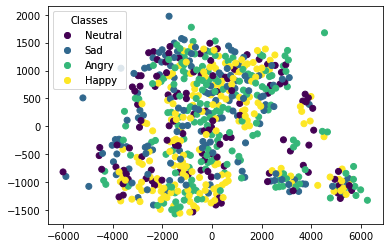

In [13]:
x1 =t.tensor(train_X[0:600])
x2 =t.tensor(train_delta_X[0:600])
x3 =t.tensor(train_delta2_X[0:600])
X = t.cat((x1, x2, x3), dim=-2)
X = X.reshape(600, -1)
X=t.from_numpy(PCA(n_components=30).fit_transform(X)).float()
#C=C[0:600]
print(X.shape)
print(X.dtype)
C=train_y[0:600]
fig, ax = plt.subplots()
res=TSNE(n_components=2,init='pca').fit_transform(X)
scatter = ax.scatter(res[:,0],res[:,1],c=C)

tsne_legend = list(scatter.legend_elements())
tsne_legend.pop(1)
labels = ['Neutral','Sad','Angry','Happy']
tsne_legend.append(labels)
tsne_legend = tuple(tsne_legend)

legend_font = {
'family': 'Times New Roman',  # 字体
'style': 'normal',
'size': 10,  # 字号
'weight': "normal",  # 是否加粗，不加粗
}
legend = ax.legend(*tsne_legend, framealpha=0.6, prop=legend_font,
                    loc="upper left", title="Classes")
ax.add_artist(legend)

#plt.yticks(fontproperties='Times New Roman', size=15,weight='bold')#设置大小及加粗
plt.yticks(fontproperties='Times New Roman')
plt.xticks(fontproperties='Times New Roman')

plt.savefig('MSP2-tsne.png',dpi=600)
plt.show()

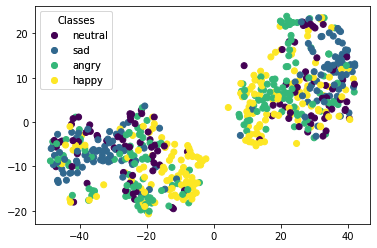

In [60]:
np.random.seed(110)
val_X=t.from_numpy(PCA(n_components=30).fit_transform(out_tsne)).float()
val_C=val_y[0:600]
fig, ax = plt.subplots()
res=TSNE(n_components=2,init='pca').fit_transform(val_X[0:600])
scatter = ax.scatter(res[:,0],res[:,1],c=val_C)

tsne_legend = list(scatter.legend_elements())
tsne_legend.pop(1)
labels = ['Neutral','Sad','Angry','Happy']
tsne_legend.append(labels)
tsne_legend = tuple(tsne_legend)
legend_font = {
'family': 'Times New Roman',  # 字体
'style': 'normal',
'size': 10,  # 字号
'weight': "normal",  # 是否加粗，不加粗
}
legend = ax.legend(*tsne_legend, framealpha=0.6, prop=legend_font,
                    loc="upper left", title="Classes")
ax.add_artist(legend)

plt.savefig('MSP2-res-tsne.png',dpi=600)
plt.show()

In [155]:
emo_num2text = {
        0: 'neutral',
        1: 'sad',
        2: 'angry',
        3: 'happy'
    }

In [163]:
np.random.seed(1111111)
val_X=t.from_numpy(PCA(n_components=30).fit_transform(out_tsne)).float()
val_C=val_y[0:600]
val_L = [emo_num2text[i] for i in val_C]

!!!!!!!!!! $\mathdefault{0}$ $\mathdefault{1}$ $\mathdefault{2}$ $\mathdefault{3}$


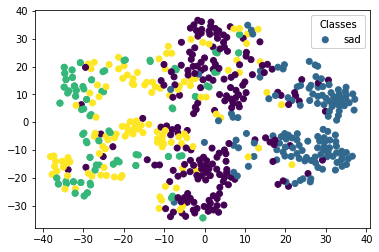

In [168]:
fig, ax = plt.subplots()
res=TSNE(n_components=2,init='pca').fit_transform(val_X)
scatter = ax.scatter(res[:,0],res[:,1],c=val_C)
print("!!!!!!!!!!", *scatter.legend_elements()[1])
legend = ax.legend(*scatter.legend_elements(),labels = val_L,
                    loc="upper right", title="Classes")
ax.add_artist(legend)

!!!!!!!!!! $\mathdefault{0}$ $\mathdefault{1}$ $\mathdefault{2}$ $\mathdefault{3}$


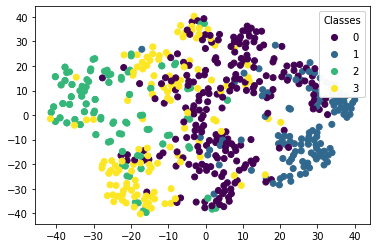

In [151]:

fig, ax = plt.subplots()
res=TSNE(n_components=2,init='pca').fit_transform(val_X)
scatter = ax.scatter(res[:,0],res[:,1],c=val_L)
print("!!!!!!!!!!", *scatter.legend_elements()[1])
legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend)

torch.Size([600, 30])
torch.float32


In [122]:
out_tsne.shape

(576, 192)

In [ ]:

print(C.shape)
print(C.dtype)
#C.dtype = 'float32'
print(C.shape)
print(C.dtype)

(600,)
int32
(600,)
int32


In [ ]:
C[0:6]

!!!!!!!!!! $\mathdefault{0}$ $\mathdefault{1}$ $\mathdefault{2}$ $\mathdefault{3}$


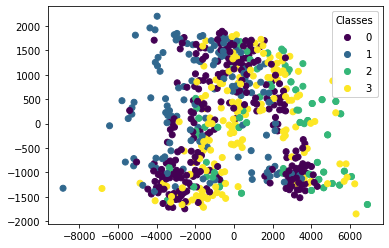

In [ ]:
np.random.seed(1968)